### Model Building 

In [ ]:
#Run the same setup after removing the Monitoring tool related tickets...
#%tensorflow_version 1.x
#import tensorflow as tf
#tf.compat.v1.disable_eager_execution()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, MaxPooling1D,Layer,Dense, Input, LSTM, Embedding, Dropout, BatchNormalization,Activation, Flatten, Bidirectional, GlobalMaxPool1D, Add, RepeatVector, TimeDistributed,concatenate
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import regularizers
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import tensorflow as tf
# Load the TensorBoard notebook extension
%load_ext tensorboard
import tensorflow as tf
import datetime, os

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel('/content/drive/My Drive/D5.1(InputData)_processed_trimmed_data_all_columns.xlsx',sheet_name='Sheet1',encoding="utf-8",dtype="str")

In [ ]:
# Removing the monitoring tool related tickets. 
df = df[df["email_type"]!="monitoring_tool"]


In [ ]:
df = df[["trimmed_words_short",
          "trimmed_words_long","Caller","email_type",
         "Assignment group","email_type",
         "new_group_75",
         "new_group_85",
         "new_group_95",
         "flg_account_related",
         "flg_crm",
         "flg_engineering",
         "flg_erp",
         "flg_failed","flg_help","flg_install",
        "flg_job","flg_laptop","flg_mobile",
        "flg_network","flg_outlook",
        "flg_printer","flg_skype",
        "flg_ticket_update","flg_vpn",
        "flg_windows","host_related",
        "blank_call","setup_ws"
]]

In [ ]:
df_features = df[["flg_account_related",
         "flg_crm",
         "flg_engineering",
         "flg_erp",
         "flg_failed","flg_help","flg_install",
        "flg_job","flg_laptop","flg_mobile",
        "flg_network","flg_outlook",
        "flg_printer","flg_skype",
        "flg_ticket_update","flg_vpn",
        "flg_windows","host_related",
        "blank_call","setup_ws"
]]

In [ ]:
df["new_group_56"] = df["new_group_75"].apply(lambda x: "GRP_0" if x == "GRP_8" 
                                              else ("GRP_0" if x=="GRP_0" else "GRP_L3"))

df1 = df[df["new_group_56"]!="GRP_0"]
#df1 = df[df["new_group_56"]!="GRP_9999"]
df["Caller"] = df["Caller"].apply(lambda x : ''.join(x.split()))

In [ ]:
df["new_group_75"].value_counts()

GRP_0       3954
GRP_9999    1893
GRP_24       289
GRP_12       249
GRP_8        245
GRP_2        241
GRP_19       213
GRP_3        200
GRP_9         68
GRP_6         60
Name: new_group_75, dtype: int64

In [ ]:
df["new_group_56"].value_counts()

GRP_0     4199
GRP_L3    3213
Name: new_group_56, dtype: int64

In [ ]:
maxlen_s = 30
maxlen_l = 100
maxlen_combo = 120
embedding_size = 200
numword1 = 2000
numword2 = 5000
numword3 = 7000

In [ ]:
def prepare_token(data,numword):
  t = Tokenizer(num_words=numword)
  t.fit_on_texts(data)
  print("Tokenization process...F1.2..", len(t.word_index)) 
  return (t)

In [ ]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [ ]:
def Glv_model(data,t):
  #print("Preparing GloVe vector...F1.3 .. token as input", len(t.word_index))
  embeddings = {}  
  if len(embeddings)==0:
    EMBEDDING_FILE = '/content/drive/My Drive/AIML_Project_Files_Final/glove.6B.200d.txt'
    embeddings = dict()
    f = open(EMBEDDING_FILE,encoding='Latin-1')
    for line in (f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:])
        embeddings[word] = coefs
    f.close()
  print("Glove being used:",len(embeddings))
  
  word_index = t.word_index
  print("t.word_index shape", len(t.word_index))  
  embedding_matrix = np.zeros((t.num_words, embedding_size))
  #print("Embedding Matrix Shape : ", embedding_matrix.shape )
  for word, i in tqdm(word_index.items()):
    if i < t.num_words:
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            #if i < 2 : print(i,embedding_matrix[i])
  return(embedding_matrix)

In [ ]:
#Tokenization and Embedding Process
t3 = prepare_token(df["Caller"]+" "+df["trimmed_words_short"]+" "+df["trimmed_words_long"],numword3)
embedding_matrix3 = Glv_model(df["trimmed_words_short"]+" "+df["trimmed_words_long"],t3)

Tokenization process...F1.2.. 16696


  9%|▊         | 1438/16696 [00:00<00:01, 14377.17it/s]

Glove being used: 399955
t.word_index shape 16696


100%|██████████| 16696/16696 [00:00<00:00, 54165.64it/s]


In [ ]:
print(t3.num_words)
print(len(t3.word_counts))

7000
16696


In [ ]:
## Data Preparation
## For Runinng the Encoder and Decoder, we need to make th
X_short_t = t3.texts_to_sequences(df["trimmed_words_short"])
X_long_t = t3.texts_to_sequences(df["trimmed_words_long"])
X_features = np.array(df_features)

X_short = pad_sequences(np.array(X_short_t), maxlen=maxlen_s, padding = 'post', truncating = 'post')
X_long = pad_sequences(np.array(X_long_t), maxlen=maxlen_l, padding = 'post', truncating = 'post')

onehot_encoder2 = OneHotEncoder(sparse=False)
y_75 = onehot_encoder2.fit_transform(np.array(df["new_group_75"]).reshape(len(df["new_group_75"]),1))

Groups = len(df["Assignment group"].value_counts())
Groups_75 = len(df["new_group_75"].value_counts())
Groups_85 = len(df["new_group_85"].value_counts())
Groups_95 = len(df["new_group_95"].value_counts())

# Split features into training and validation sets
X_train_s, X_val_s, X_train_l,X_val_l,X_train_feature,X_val_feature,y_train_75,y_val_75 = train_test_split(X_short,X_long,X_features,y_75,test_size=0.20, random_state=15)

print("X_train_s Shape : ",X_train_s.shape)
print("X_val_s Shape : ",X_val_s.shape)
print("X_features Shape : ",X_features.shape)
print("X_features train Shape : ",X_train_feature.shape)

print("y_train_75 Shape : ",y_train_75.shape)


print("Group counts : ",Groups,Groups_75,Groups_85,Groups_95)


X_train_s Shape :  (5929, 30)
X_val_s Shape :  (1483, 30)
X_features Shape :  (7412, 20)
X_features train Shape :  (5929, 20)
y_train_75 Shape :  (5929, 10)
Group counts :  74 10 18 36


In [ ]:
model_results = pd.DataFrame(columns = ['input_x','target_y','unique_target', 'training_acc','validation_acc',
                                        'training_loss','validation_loss','glove_vector','attn_layer','conv1d',
                                        'no_of_epochs_run','batch_size','learning_rate','embb_trainable'])

In [ ]:
def encoder_decoder(t,embedding_matrix,glove,glv_t=False):
    # Model with Short description..............
    short_desc_input = Input(shape=(maxlen_s,))
    embedded_sequences = Embedding(t.num_words, embedding_size,weights = [embedding_matrix], trainable = glv_t)(short_desc_input)
    short_lstm = Bidirectional(LSTM(50, return_sequences=True, dropout=0.2))(embedded_sequences)
    short_dense = TimeDistributed(Dense(50))(short_lstm)
    dropout1 = Dropout(0.3)(short_dense)
    short_flatten = Flatten()(dropout1)

    # Model with Long description..............
    long_input = Input(shape=(maxlen_l,))
    long_embedded_sequences = Embedding(t.num_words, embedding_size,weights = [embedding_matrix], trainable = glv_t)(long_input)
    long_lstm = Bidirectional(LSTM(50, return_sequences=True, dropout = 0.2))(long_embedded_sequences)
    long_dense = Dense(50, activation='relu',
                      kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(long_lstm)
    dropout2 = Dropout(0.3)(long_dense)
    long_flatten = Flatten()(dropout2)

    #Concate both the end Layers ....................
    description_output = concatenate([short_flatten, long_flatten])
    preds = Dense(10, activation='softmax')(description_output)

    #Final model and compiling.................
    model_r = Model([short_desc_input, long_input], [preds])
    model_r.compile(optimizer='Adam',loss= 'categorical_crossentropy',metrics = ['accuracy','mse'])
    return(model_r)  

In [ ]:
#Plot the Accuracy and Loss on the graph to represent the trend
def plot_history(history,D,T,Groups,glv,n,glv_tr,batch_size):
    fig = plt.figure(figsize = (20, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Validation Acc')
    print("\n Data set : "+D+" & "+T+";  No of Output Groups: "+str(Groups)+" ; GloVe vector used : "+glv+" itr  - "+str(n)+" embb.trainable :"+str(glv_tr)+' batch size:' +str(batch_size))
    plt.title("Accuracy")
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title("Loss")
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(history.history['lr'], label='lr rate')
    plt.title("learning rate")
    plt.legend()
    plt.grid()
    
    plt.show()

In [ ]:
%tensorboard --logdir logs

1 0
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 200)      1400000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 200)     1400000     input_2[0][0]                    
__________________________________________________________________________________________

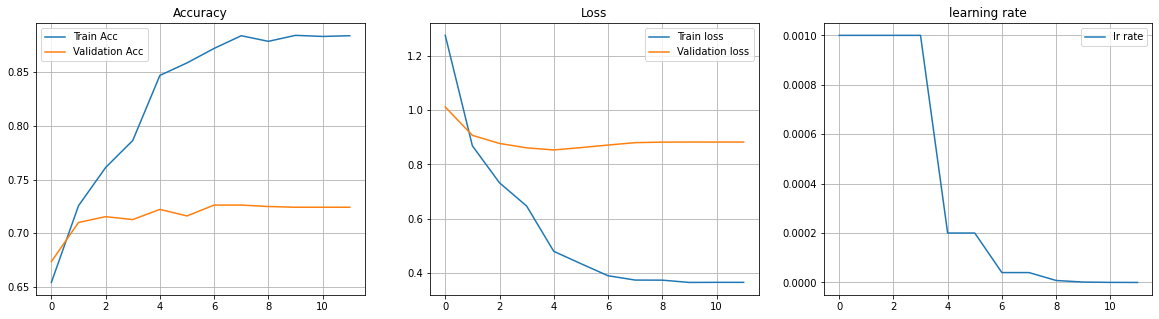

1 1

 Data set : short_long & y_75;  No of Output Groups: 10 ; GloVe vector used : yes itr  - 2 embb.trainable :False batch size:16


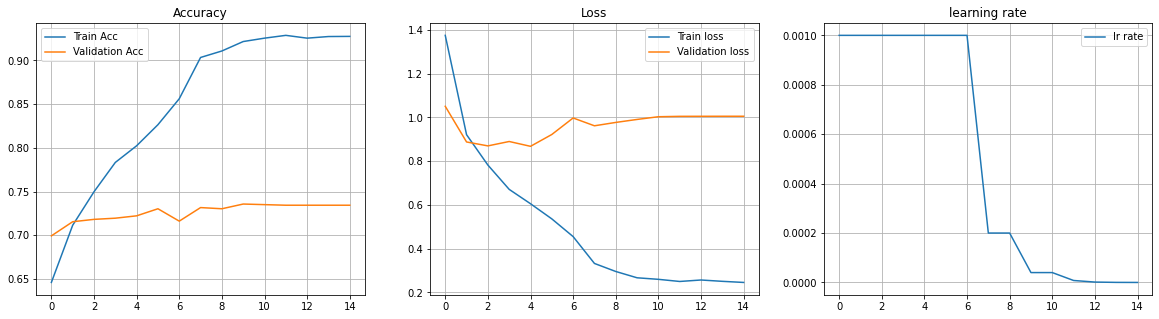

1 2

 Data set : short_long & y_75;  No of Output Groups: 10 ; GloVe vector used : yes itr  - 3 embb.trainable :False batch size:32


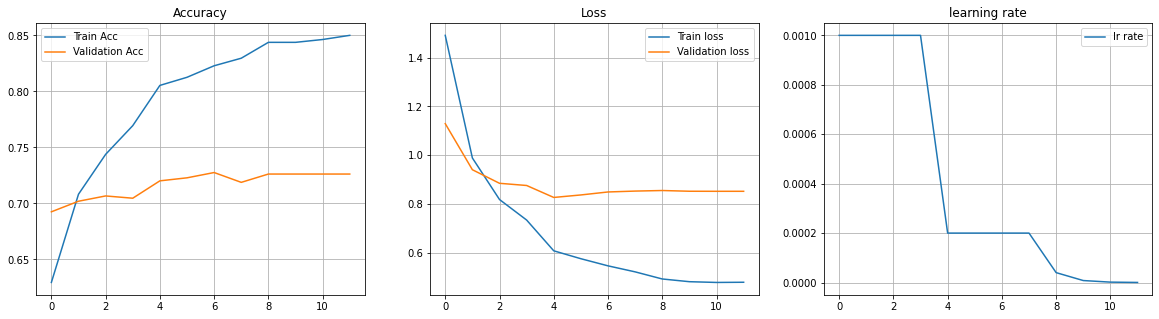

1 3

 Data set : short_long & y_75;  No of Output Groups: 10 ; GloVe vector used : yes itr  - 4 embb.trainable :False batch size:100


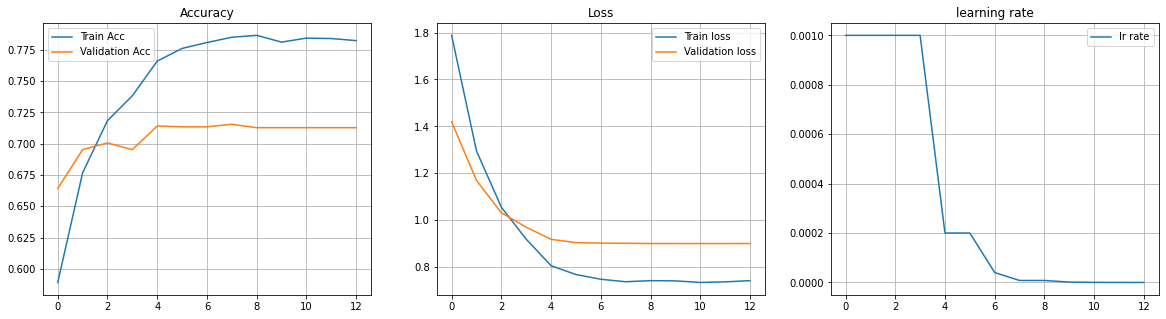

1 4

 Data set : short_long & y_75;  No of Output Groups: 10 ; GloVe vector used : yes itr  - 5 embb.trainable :True batch size:8


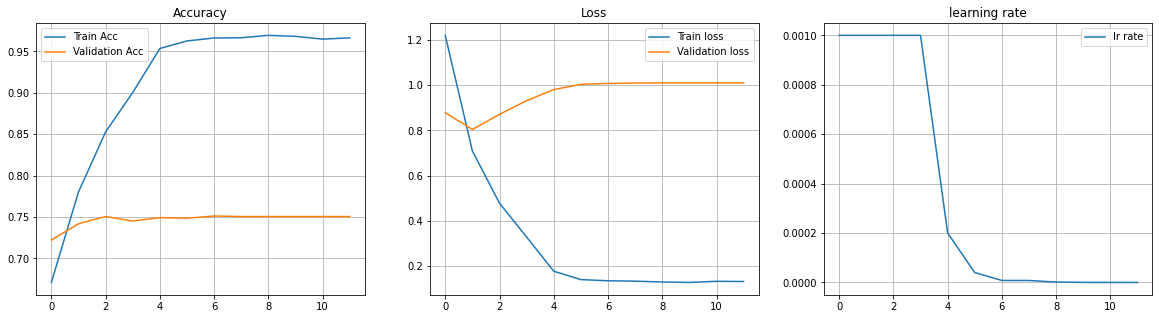

1 5

 Data set : short_long & y_75;  No of Output Groups: 10 ; GloVe vector used : yes itr  - 6 embb.trainable :True batch size:16


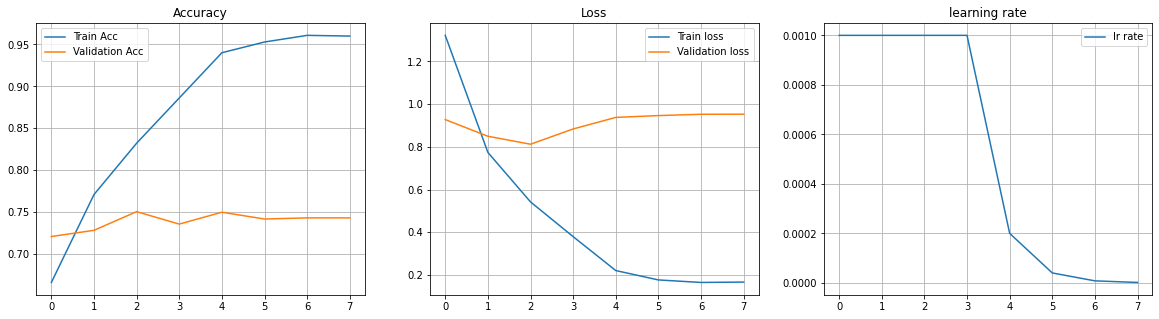

1 6

 Data set : short_long & y_75;  No of Output Groups: 10 ; GloVe vector used : yes itr  - 7 embb.trainable :True batch size:32


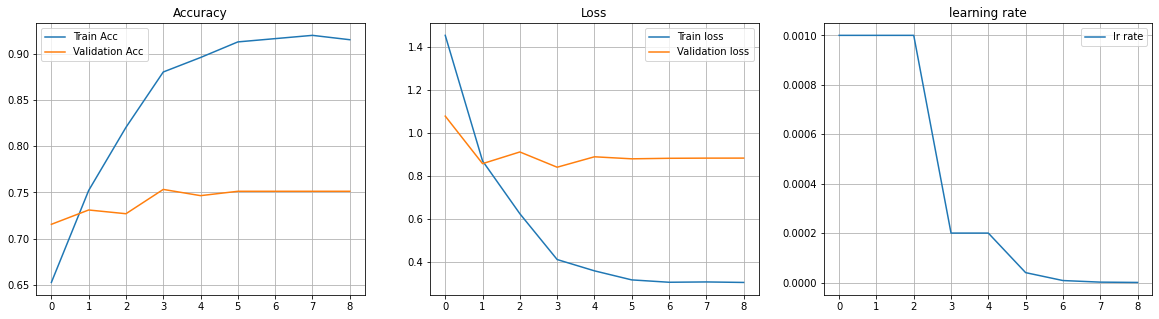

1 7

 Data set : short_long & y_75;  No of Output Groups: 10 ; GloVe vector used : yes itr  - 8 embb.trainable :True batch size:100


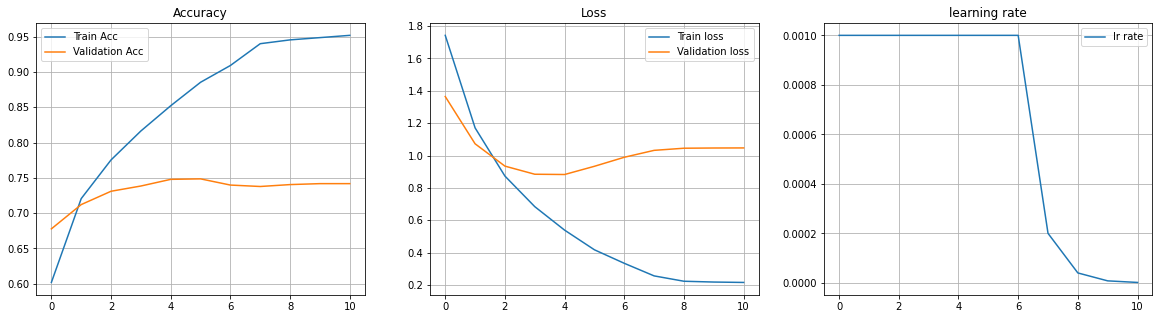

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)
reduce_lr = (ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=1, min_lr=0.00000001))
early_stop = (EarlyStopping(monitor='val_accuracy', patience=5))
epochs = 100
batch_size = 16
n=0
glv_tr = False
for glove in (1,):
  for glv_tr in (False,True):
    for batch_size in(8,16,32,100):
      if glove ==1 : glv = "yes"
      else : glv = "no"
      print(glove,n)
      for X_inputs in (3,):
          t = t3
          embedding_matrix = embedding_matrix3
          Groups = Groups_75
          D = "short_long"
          T = "y_75"
          model1 = encoder_decoder(t,embedding_matrix,glove,glv_tr)
          if n==0 : print(model1.summary())
          history = model1.fit((X_train_s,X_train_l),y_train_75, 
                                validation_data = ((X_val_s,X_val_l),y_val_75),  
                                epochs = epochs, batch_size = batch_size,
                                callbacks = [tensorboard_callback,reduce_lr,early_stop], verbose = 0)
          db1 = ({'input_x': D ,
          'target_y' : T,
          'unique_target' :10  , 
          'training_acc' : history.history['accuracy'][len(history.history['accuracy'])-1],
          'validation_acc' : history.history['val_accuracy'][len(history.history['accuracy'])-1],
          'training_loss': history.history['loss'][len(history.history['accuracy'])-1],
          'validation_loss' : history.history['val_loss'][len(history.history['accuracy'])-1],
          'glove_vector': glv,
          'attn_layer': "no",
          'conv1d': "yes",
          'no_of_epochs_run': len(history.history['accuracy']),
          'batch_size': batch_size,
          'learning_rate': history.history['lr'][len(history.history['accuracy'])-1],
          'embb_trainable' : glv_tr })
          model_results = model_results.append(db1, ignore_index = True)
          n=n+1    
          plot_history(history,D,T,Groups_75,glv,n,glv_tr,batch_size)

In [ ]:
model_results

,input_x,target_y,unique_target,training_acc,validation_acc,training_loss,validation_loss,glove_vector,attn_layer,conv1d,no_of_epochs_run,batch_size,learning_rate,embb_trainable
0,short_long,y_75,10,0.883792,0.724208,0.364904,0.882663,yes,no,yes,12,8,6.400001e-08,False
1,short_long,y_75,10,0.927475,0.734322,0.245713,1.004760,yes,no,yes,15,16,6.400001e-08,False
2,short_long,y_75,10,0.850059,0.726231,0.478207,0.851736,yes,no,yes,12,32,3.200000e-07,False
3,short_long,y_75,10,0.782257,0.712744,0.741052,0.899478,yes,no,yes,13,100,1.280000e-08,False
4,short_long,y_75,10,0.966268,0.750506,0.131864,1.010374,yes,no,yes,12,8,1.280000e-08,True
5,short_long,y_75,10,0.960027,0.743088,0.166926,0.952737,yes,no,yes,8,16,1.600000e-06,True
6,short_long,y_75,10,0.915163,0.751180,0.305454,0.882655,yes,no,yes,9,32,3.200000e-07,True
7,short_long,y_75,10,0.951762,0.741740,0.215844,1.047171,yes,no,yes,11,100,1.600000e-06,True


In [ ]:
model_results.to_csv("results_28_Jun_2020_Run6.csv")